In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.current_device())  # Should print 0 (or another device index)
print(torch.cuda.get_device_name(0))  # Should print "NVIDIA GeForce RTX 4070 Super"



True
0
NVIDIA GeForce RTX 4070 SUPER


In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Step 1: Define Paths and Split Data
base_dir = '/Users/hunte/Desktop/PetImages'
dog_dir = os.path.join(base_dir, 'Dog')
cat_dir = os.path.join(base_dir, 'Cat')

dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.endswith('.jpg')]
cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.endswith('.jpg')]

# Filter out corrupt images
def is_valid_image(file):
    try:
        img = Image.open(file)
        img.verify()  # Verify that it’s a valid image
        return True
    except:
        return False

dog_files = [f for f in dog_files if is_valid_image(f)]
cat_files = [f for f in cat_files if is_valid_image(f)]

c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
# Split into train and validation
dog_train, dog_val = train_test_split(dog_files, test_size=0.2, random_state=42)
cat_train, cat_val = train_test_split(cat_files, test_size=0.2, random_state=42)

train_files = dog_train + cat_train
val_files = dog_val + cat_val
train_labels = [1] * len(dog_train) + [0] * len(cat_train)  # 1=dog, 0=cat
val_labels = [1] * len(dog_val) + [0] * len(cat_val)

In [10]:
# Step 2: Custom Dataset
class PetDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Data Augmentation and Preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.7, 1.3)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Datasets and DataLoaders
train_dataset = PetDataset(train_files, train_labels, transform=train_transforms)
val_dataset = PetDataset(val_files, val_labels, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [11]:
# Step 3: Define CNN Model
class PetCNN(nn.Module):
    def __init__(self):
        super(PetCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = PetCNN().to(device)
print(model)

PetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_featu

In [ ]:
# Step 4: Loss, Optimizer, and Metrics
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Step 5: Training Loop with Checkpoint
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0.0
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    print("Entering training loop...", flush=True)

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss / len(val_loader))

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')

    return history



In [13]:
print("Testing train_loader...", flush=True)
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}", flush=True)

Testing train_loader...
Batch shape: torch.Size([32, 3, 128, 128]), Labels shape: torch.Size([32])


In [14]:
# Train the model
history = train_model(model, train_loader, val_loader)

Entering training loop...
Epoch 1, Batch 1/625
Data on device: cuda:0
Epoch 1, Batch 2/625
Data on device: cuda:0
Epoch 1, Batch 3/625
Data on device: cuda:0
Epoch 1, Batch 4/625
Data on device: cuda:0
Epoch 1, Batch 5/625
Data on device: cuda:0
Epoch 1, Batch 6/625
Data on device: cuda:0
Epoch 1, Batch 7/625
Data on device: cuda:0
Epoch 1, Batch 8/625
Data on device: cuda:0
Epoch 1, Batch 9/625
Data on device: cuda:0
Epoch 1, Batch 10/625
Data on device: cuda:0
Epoch 1, Batch 11/625
Data on device: cuda:0
Epoch 1, Batch 12/625
Data on device: cuda:0
Epoch 1, Batch 13/625
Data on device: cuda:0
Epoch 1, Batch 14/625
Data on device: cuda:0
Epoch 1, Batch 15/625
Data on device: cuda:0
Epoch 1, Batch 16/625
Data on device: cuda:0
Epoch 1, Batch 17/625
Data on device: cuda:0
Epoch 1, Batch 18/625
Data on device: cuda:0
Epoch 1, Batch 19/625
Data on device: cuda:0
Epoch 1, Batch 20/625
Data on device: cuda:0
Epoch 1, Batch 21/625
Data on device: cuda:0
Epoch 1, Batch 22/625
Data on device: 

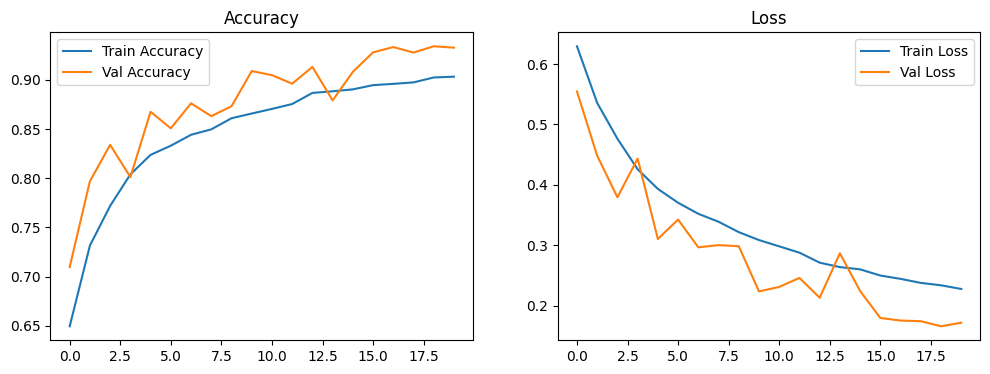

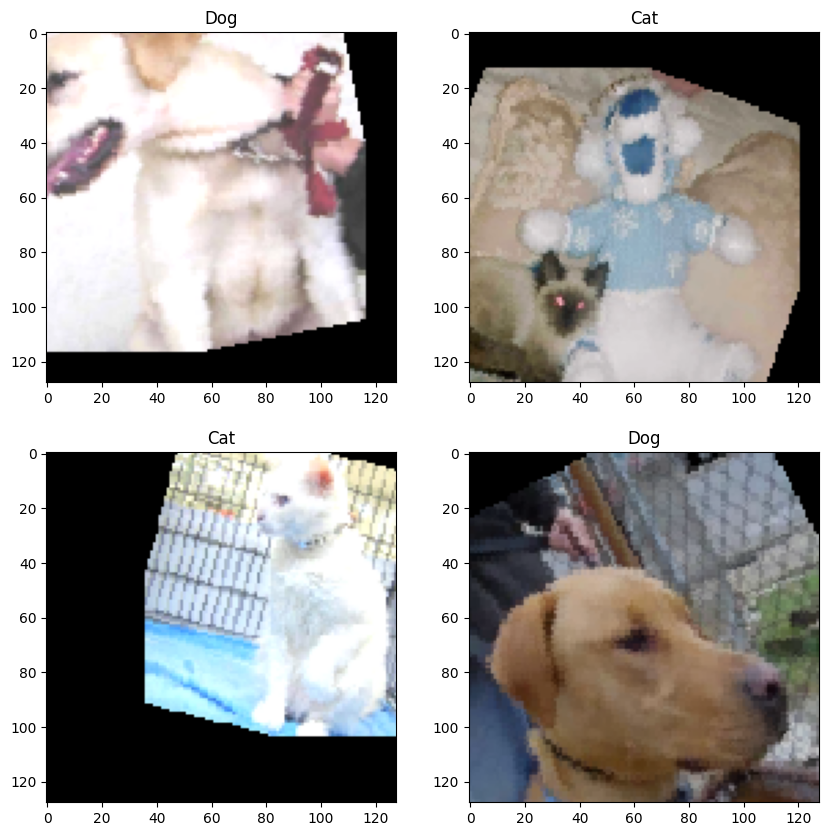

In [15]:
# Step 6: Visualize Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Bonus: Visualize Augmented Images
model.eval()
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images[:4].to(device), labels[:4].to(device)

plt.figure(figsize=(10, 10))
for i in range(4):
    img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
    img = img * 0.5 + 0.5  # Denormalize
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title('Cat' if labels[i].item() == 0 else 'Dog')
plt.show()